In [1]:
from IPython.core.display import HTML
HTML("""
<style>
code {
    padding:2px 4px !important;
    color: #c7254e !important;
    font-size: 90%;
    background-color: #f9f2f4 !important;
    border-radius: 4px !important;
    color: rgb(138, 109, 59);
}
mark {
    color: rgb(138, 109, 59) !important;
    font-weight: bold !important;
}
.container { width: 90% !important; }
table { font-size:15px !important; }
</style>
""")

In [2]:
import sys, math, os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt    
import numpy as np
from collections import defaultdict
from collections import Counter
import itertools
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

sys.path.insert(0, '../../src/data/')
import utils

%matplotlib inline
%load_ext autoreload  
%autoreload 2  

path_raw = "../../data/raw/beer_reviews"
assert os.path.isfile(os.path.join(path_raw, 'beer_reviews.csv')), "This data file doesn't exist yet, please run through 'make data'"

# Introduction

The goal of this notebook is to try and answer the question
> If you had to pick 3 beers to recommend using only this data, which would you pick?

## Initial thoughts

This question is quite open ended, best beer might be interpreted in the following ways:
- best overall beers in entire dataset
- best beers per `beer_type`
- best can be rated by any or a combination of the beer attributes: `review_overall`, `review_aroma`, `review_appearance`, `review_tast`, `review_palate`, `beer_abv`

**NOTE**: analysis [1.0_initial_look](1.0_initial_look.ipynb) identified various attributes with missing data that may impact this analysis:
- `beer_abv` not available for all beers
- `review_profilename` not available for each review -> it's uncertain what happend with this data - consider excluding?

In [3]:
# LOAD DATA
# we assume the file we're after is a
# single .csv in path_raw
for file in os.listdir(path_raw):
    file = os.path.join(path_raw, file)
    if os.path.isfile(file) and '.csv' in file: 
        dat_raw = pd.read_csv(file, encoding='utf-8') # NOTE: force utf-8 encoding because some beer_styles have accents in them
        
dat_raw.head()

# DF of beer metadata
beer_meta_cols = ['brewery_id', 'brewery_name','beer_style', 'beer_name','beer_abv']
beer_dat = dat_raw.groupby('beer_beerid').agg('first')[beer_meta_cols]

<hr>

## Checking missing data

In [4]:
print 'Num reviews without a profilename: ', dat_raw[dat_raw.review_profilename.isnull()].shape[0]
print 'Num reviews with a profilename: ', dat_raw[dat_raw.review_profilename.notnull()].shape[0]

Num reviews without a profilename:  348
Num reviews with a profilename:  1586266


<mark>Given that those reviews without a profilename represent a small fraction of the total reviews, we will exclude these reviews from the analysis.</mark>

In [5]:
# create new copy of data without reviews with missing profilename
dat = dat_raw[dat_raw.review_profilename.notnull()].copy()

For now, we will only consider the `review_overall` score in order to gauge a beer; we do this because it is assumed this metric is some sort of aggregating metric over all the other beer attribute scores and thus gives a good, generalized metric for "goodness".

In [6]:
# naively check average review_overall score for each beer
score_cols = ['review_overall','review_aroma','review_appearance','review_taste','beer_abv']
avg_scores = dat.groupby('beer_beerid').mean()[score_cols]
avg_scores.columns = ['avg ' + l for l in score_cols]
avg_scores.head()

counts = dat.groupby('beer_beerid').count()[['brewery_id']]
counts.columns = ['number of reviews']

perfect = dat[dat.review_overall==5].groupby('beer_beerid').count()[['brewery_id']]
perfect.columns = ['counts with top score']

avg_scores = avg_scores.merge(counts, left_index=True, right_index=True)
avg_scores = avg_scores.merge(perfect, left_index=True, right_index=True)
avg_scores = avg_scores.merge(beer_dat[['brewery_name','beer_style','beer_name']], left_index=True, right_index=True)

avg_scores.sort_values('avg review_overall', ascending=False).head(10)

,avg review_overall,avg review_aroma,avg review_appearance,avg review_taste,avg beer_abv,number of reviews,counts with top score,brewery_name,beer_style,beer_name
beer_beerid,,,,,,,,,,
77303,5.0,4.50,4.5,4.50,5.8,1,1,The Bier Brewery,English Stout,Fuggit Stout
63470,5.0,3.50,3.0,4.50,NaN,1,1,Broad Ripple Brew Pub,Kölsch,Kölsch
63829,5.0,3.50,4.0,3.50,8.5,1,1,Le Siboire,American Strong Ale,IABA
63746,5.0,3.50,4.0,4.00,NaN,1,1,Fitger's Brewhouse,American Pale Ale (APA),Ely's Peak
63735,5.0,4.00,4.0,4.50,5.4,1,1,Ninkasi Fabriques,Witbier,Biere Blanche
42392,5.0,4.75,4.0,4.75,5.2,2,2,Lunar Brewing,English Brown Ale,Nebula Nut Brown Ale
16043,5.0,3.50,4.0,5.00,7.0,1,1,Chelsea Brewing Company,American Double / Imperial Stout,Old Black Boot
42501,5.0,4.00,3.5,4.50,NaN,1,1,Cornelius Pass Roadhouse & Imbrie Hall (McMena...,Saison / Farmhouse Ale,Farmhouse Ale
63692,5.0,4.00,4.5,4.00,NaN,1,1,High Point Brewing Company,American IPA,Ramstein India Pale Ale


This method won't work because beers aren't equally reviewed.

## Identifying trolls

In [7]:
# check whether any reviewers are trolls (e.g. always scoring the same thing)
reviewer_scores = dat.groupby('review_profilename').agg(['mean','median','count','std'])[['review_overall']]
reviewer_scores.columns = ['mean review_overall','median review_overall', 'count reviews', 'std review_overall']

# DANGER: magic numbers
min_reviews_troll = 3 # a reviewer must have had more than this many reviews in order to be considered a troll
min_std_troll = 0 # reviewers with a std(review_overall) greater than this value are considered NOT trolls
trolls = reviewer_scores[(reviewer_scores['count reviews'] > min_reviews_troll) & (reviewer_scores['std review_overall']<=min_std_troll)]

trolls.to_csv('../../data/interim/trolls.csv') # write to file for later use

print '%s trolls found' %trolls.shape[0]

trolls.head(10)

50 trolls found


,mean review_overall,median review_overall,count reviews,std review_overall
review_profilename,,,,
Bankhead,5.0,5.0,10,0.0
BrewTat,1.0,1.0,6,0.0
BrewedAwakening,5.0,5.0,4,0.0
Brianito,4.5,4.5,4,0.0
BrotherJon,4.0,4.0,6,0.0
Claudehenrysmoot,4.0,4.0,4,0.0
GIG,5.0,5.0,4,0.0
HapWifeHapLife,4.0,4.0,4,0.0
Hoppynanobeer,5.0,5.0,4,0.0


## Identifying best beer

In [8]:
# get the top n beers for each reviewer 
best_beers_dict = defaultdict(list) # {profile_name: [list of beers rated 5]}

n = 3 # number of top beers to return per reviewer DANGER: magic number
min_num_reviews = 1 # minimum number of reviews a reviewer must have done in order to consider their opinion DANGER: magic number

for name, df in dat.groupby('review_profilename'):
    if df.shape[0] > min_num_reviews and name not in trolls.index:
        best_beers_dict[name] = utils.get_highest_rated_beers(df, n=n)

In [9]:
# calculate the number of times each beer was identified as a best beer
all_best_beers = list(itertools.chain.from_iterable(best_beers_dict.values()))
best_beers_counts = Counter(all_best_beers)

best_beers = pd.DataFrame(best_beers_counts, index=[0]).transpose()
best_beers.columns = ['counts as best beer']
best_beers.index.name = 'beer_beerid'

# add column for average overall score
best_beers = best_beers.merge(avg_scores, 
                              left_index=True, 
                              right_index=True).sort_values('counts as best beer', ascending=False)

best_beers.to_csv('../../data/interim/best_beers.csv', encoding='utf-8')

top10 = best_beers.head(10)
top10

,counts as best beer,avg review_overall,avg review_aroma,avg review_appearance,avg review_taste,avg beer_abv,number of reviews,counts with top score,brewery_name,beer_style,beer_name
beer_beerid,,,,,,,,,,,
7971,1362,4.590028,4.612188,4.388603,4.630985,8.0,2527,1067,Russian River Brewing Company,American Double / Imperial IPA,Pliny The Elder
695,909,4.342180,4.151082,4.512862,4.329522,8.5,2449,591,Brouwerij Duvel Moortgat NV,Belgian Strong Pale Ale,Duvel
731,898,4.516414,4.296465,4.381061,4.425505,5.4,1980,695,Bayerische Staatsbrauerei Weihenstephan,Hefeweizen,Weihenstephaner Hefeweissbier
17112,882,4.377609,4.533156,4.242530,4.518420,10.0,2443,630,"Bell's Brewery, Inc.",American Double / Imperial IPA,Bell's Hopslam Ale
1093,854,4.330216,4.266593,4.154199,4.319399,7.0,2727,554,"Bell's Brewery, Inc.",American IPA,Two Hearted Ale
11757,847,4.354658,4.412035,4.364454,4.501200,8.3,2501,507,Founders Brewing Company,American Double / Imperial Stout,Founders Breakfast Stout
2093,840,4.145485,4.213439,4.192156,4.325935,9.0,3289,396,Dogfish Head Brewery,American Double / Imperial IPA,90 Minute IPA
34,791,4.298027,4.231977,4.193919,4.396093,9.0,2483,492,Unibroue,Tripel,La Fin Du Monde
276,772,4.245845,3.915539,3.995168,4.115385,5.6,2587,416,Sierra Nevada Brewing Co.,American Pale Ale (APA),Sierra Nevada Pale Ale


## Effect size

In [10]:
effect_size = dict()
for beer in top10.index:
    a = dat_raw[dat_raw.beer_beerid==beer].review_overall
    b = dat_raw[dat_raw.beer_beerid!=beer].review_overall
    effect_size[beer] = utils.cohen_d(a,b)
    
effect_size = pd.DataFrame(effect_size, index=[0]).transpose()
effect_size.columns = ['cohen_d']
effect_size.sort_values('cohen_d', ascending=False)

,cohen_d
7971,1.077399
731,0.973617
17112,0.781491
11757,0.749388
695,0.732279
1093,0.715020
34,0.670770
276,0.598222
412,0.498780
2093,0.459217


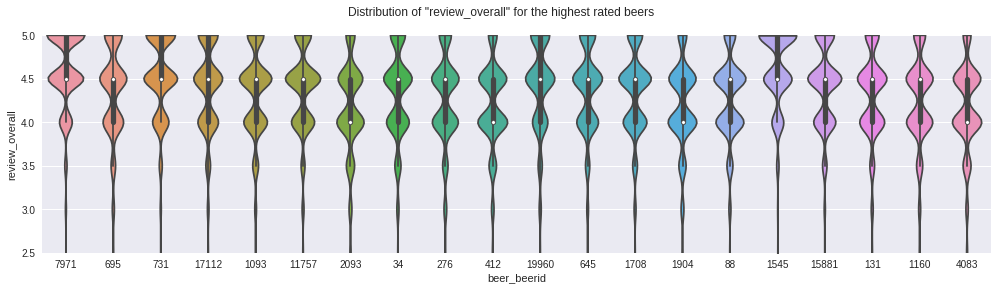

In [11]:
best_n = 20
x = best_beers.index.tolist()[:best_n]
tmp = dat[dat.beer_beerid.isin(x)]

plt.figure(figsize=(17,4))
ax = sns.violinplot(x="beer_beerid", y="review_overall", data=tmp, order=x, cut=0)
plt.suptitle('Distribution of "review_overall" for the highest rated beers')
plt.ylim([2.5,5])
plt.savefig('../../reports/figures/3.0_recommend_3_beers-0.svg')
plt.savefig('../../reports/figures/3.0_recommend_3_beers-0.png')